# Concevez une application au service de la santé publique

## Analyse de nos données

In [1]:
import pandas as pd
import numpy as np

import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy
from scipy.stats import chi2_contingency
import sklearn
from sklearn import preprocessing
from sklearn import decomposition

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import IPython
from IPython.display import Image, HTML

In [2]:
print('pandas version : ', pd.__version__, '\n')
print('numpy version : ', np.__version__, '\n')
print('statsmodels version : ', statsmodels.__version__, '\n')
print('scipy version : ', scipy.__version__, '\n')
print('sklearn version : ', sklearn.__version__, '\n')
print('matplotlib version : ', matplotlib.__version__, '\n')
print('seaborn version : ', sns.__version__, '\n')
print('IPython version : ', IPython.__version__)

pandas version :  1.2.4 

numpy version :  1.20.1 

statsmodels version :  0.12.2 

scipy version :  1.6.2 

sklearn version :  0.24.1 

matplotlib version :  3.3.4 

seaborn version :  0.11.2 

IPython version :  7.22.0


In [3]:
#On charge notre jeu de données qui n'a plus de valeurs manquantes ou aberrantes.
df = pd.read_csv('data_to_analyze.csv', low_memory = False)

### Analyses univariées

In [4]:
#Pour plus de facilité lors de nos analyses, on renomme notre colonne du gras saturé en enlevant le tiret "-".
df.rename(columns = {'saturated-fat_100g': 'saturated_fat_100g'}, inplace = True)

#On crée aussi une colonne de nutriscore_grade avec des valeurs numériques pour plus de facilité.
df['nutriscore_grade_distrib'] = \
df['nutriscore_grade'].replace(['a', 'b', 'c', 'd', 'e'], [1 ,2 ,3 ,4 ,5])

#On supprime la colonne "Unnamed: 0" qui a été créée lors de l'enregistrement de notre jeu de données.
df.drop(columns = ['Unnamed: 0'], inplace = True)

Nous allons analyser les colonnes suivantes : "nutriscore_score", "nutriscore_grade_distrib", "energy_100g", "saturated_fat_100g", "sugars_100g", "proteins_100g" et "sodium_100g" (nos scores et ce qui peut influer négativement ou positivement sur nos scores).

Nous créons une fonction afin de ne pas réécrire plusieurs fois notre code mettant en avant les différentes caractéristiques de nos variables.

In [1]:
def univariee(col, data = df):
    """
    Prend une variable d'un dataframe et retourne les mesures de tendance centrale (moyenne, médiane, mode),
    les mesures de dispersion (variance, écart-type), les mesures de forme (skewness empirique et kurtosis
    empirique) et les mesures de concentration (indice de Gini) de la variable choisie.
    Pour une visualisation graphique, retourne également l'histogramme, la boîte à moustache ainsi que la
    courbe de Lorenz de la variable choisie.
    
            Parameters:
                col (object): variable que l'on souhaite étudier
                data : dataframe à utiliser
    """
    
    #On vérifie que la variable en entrée est bien numérique
    if ((data[col].dtype == float) | (data[col].dtype == np.int64)):
        
        #Mesures de tendances centrales et de dispersion de la variable
        print(col)
        print('moyenne :', round(data[col].mean(), 2))
        print('médiane :', round(data[col].median(), 2))
        print('mode :', data[col].mode())
        print('variance :', round(data[col].var(), 2))
        print('écart-type :', round(data[col].std(), 2))

        #Histrogramme de la distribution de la variable
        sns.set_context('notebook', font_scale = 1.25)
        plt.style.use('seaborn-darkgrid')
        plt.figure(figsize = (8, 8))
        plt.hist(x = data[col].values, bins = 50, align = 'left', color = '#4d7cab', \
             edgecolor = 'black', linewidth = 1.1)
        plt.title('Distribution de la variable : {}'.format(col))
        plt.show()

        #Boxplot de la variable
        plt.figure(figsize = (8, 8))
        data.boxplot(column = col, vert = False, sym = "", showmeans = True)
        plt.title('Boîte à moustache de la variable : {}'.format(col))
        plt.show()

        #Mesures de forme
        print(col, 'skewness :', data[col].skew(), '\n')
        if data[col].skew() == 0:
            print('La distribution est symmétrique et ')
            print('kurtosis :', data[col].kurtosis(), '\n')
            if data[col].kurtosis() > 0:
                print('Les observations sont plus concentrées que la distribution normale.', '\n')
            elif data[col].kurtosis() < 0:
                print('Les observations sont moins concentrées que la distribution normale.', '\n')
            else:
                print('La distribution a le même aplatissement que la distribution normale')
        elif data[col].skew() > 0:
            print('La distribution est étalée à droite', '\n')
        else:
            print('La distribution est étalée à gauche', '\n')

        #Mesures de concentration
        n = len(data[col])
        lorenz = np.cumsum(np.sort(data[col]))/data[col].sum()
        lorenz = np.append([0], lorenz)

        plt.figure(figsize = (8, 8))
        plt.axes().axis('equal')
        xaxis = np.linspace(0 - 1/n, 1 + 1/n, n+1)
        plt.plot(xaxis, lorenz, drawstyle = 'steps-post')
        plt.plot([0,1], [0,1], color = 'black')
        plt.title('Courbe de Lorenz de la variable : {}'.format(col))
        plt.show()

        AUC = (lorenz.sum() - lorenz[-1]/2 - lorenz[0]/2)/n
        S = 0.5 - AUC
        gini = 2*S
        print('Indice de Gini de', col, ':', gini)
        
    else:
        print('Erreur : Merci de prendre une colonne qui a des valeurs numériques !')

NameError: name 'df' is not defined

energy_100g
moyenne : 1137.02
médiane : 1105.0
mode : 0    0.0
dtype: float64
variance : 581156.52
écart-type : 762.34


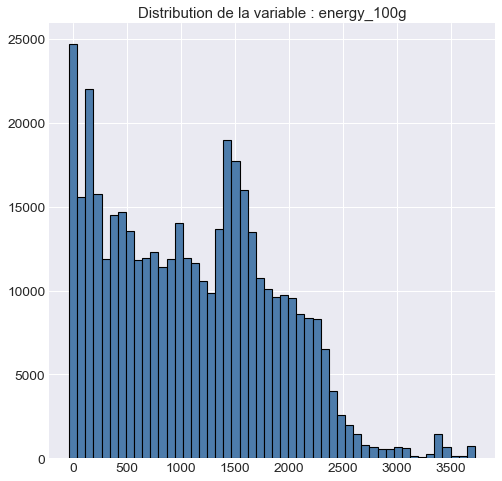

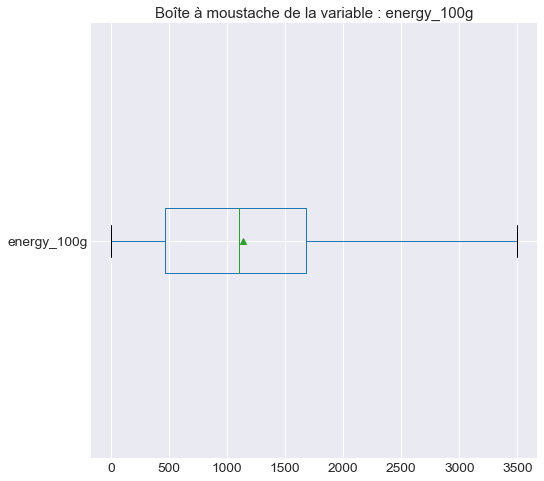

energy_100g skewness : 0.3682840690172967 

La distribution est étalée à droite 



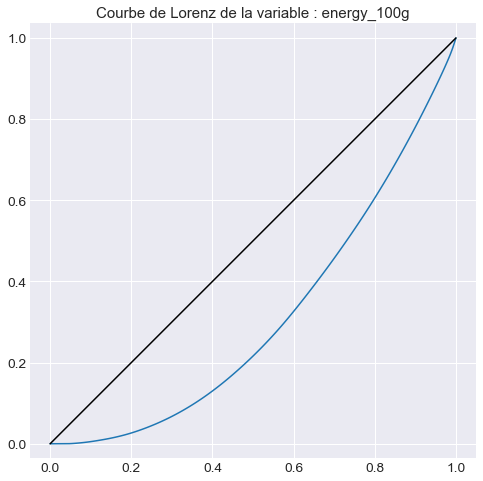

Indice de Gini de energy_100g : 0.3817423315752737


In [6]:
univariee('energy_100g')

75% des produits ont une valeur énergétique comprise entre 0 et 1700kJ. On peut tout de même remarquer que certains produits peuvent avoir une valeur énergétique de 3500kJ ou au-delà.

La distribution est légèrement inégalitaire : 50% de mes produits représentent environ 20% des valeurs énergétiques. C'est confirmé par un indice de Gini de 0.38.

saturated_fat_100g
moyenne : 5.21
médiane : 2.0
mode : 0    0.0
dtype: float64
variance : 56.58
écart-type : 7.52


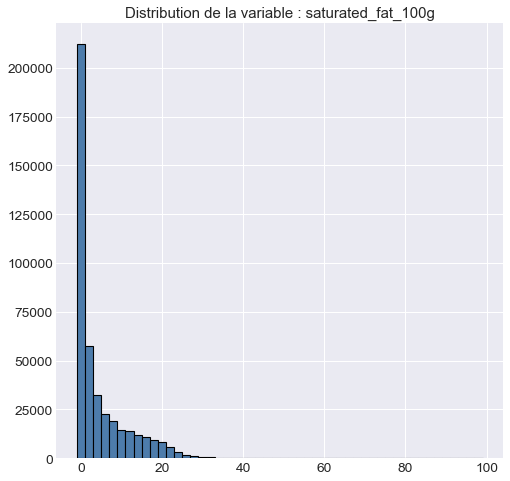

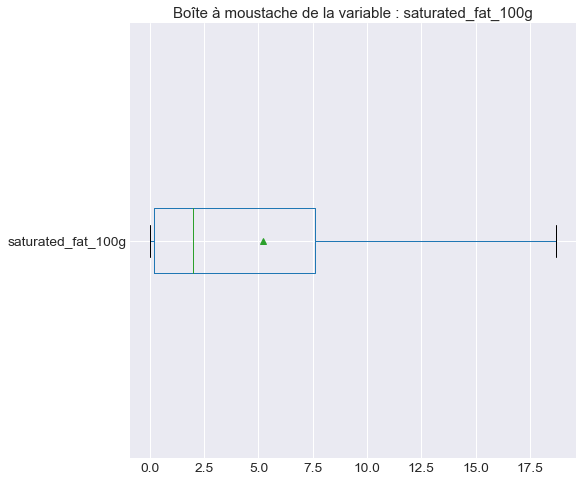

saturated_fat_100g skewness : 2.896462026991375 

La distribution est étalée à droite 



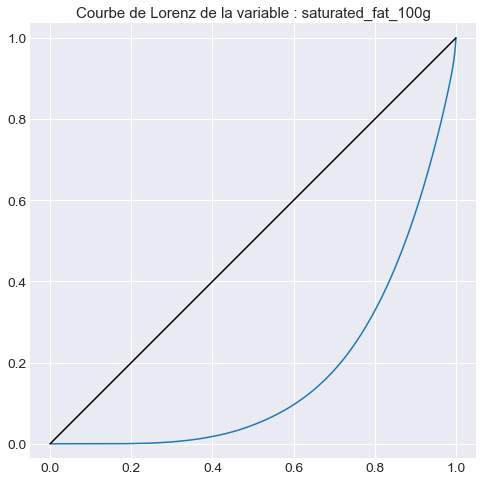

Indice de Gini de saturated_fat_100g : 0.6631789210092549


In [7]:
univariee('saturated_fat_100g')

75% des produits ont entre 0 et 7.5g de gras saturés pour 100g de produits, très peu de produits ont plus.

La distribution est très inégalitaire (indice de Gini de 0.66) : 60% des produits représentent environ 10% des valeurs de la distribution.

sugars_100g
moyenne : 14.46
médiane : 4.0
mode : 0    0.0
dtype: float64
variance : 405.48
écart-type : 20.14


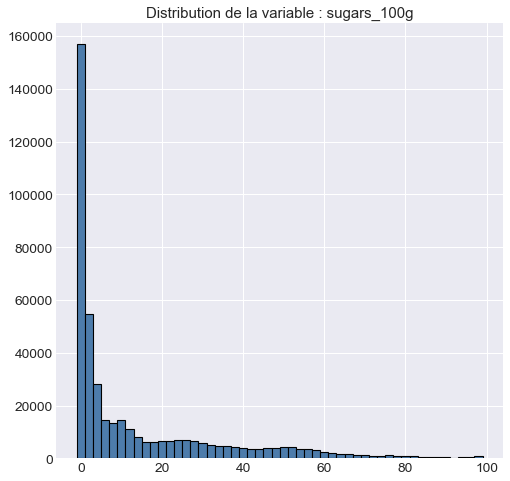

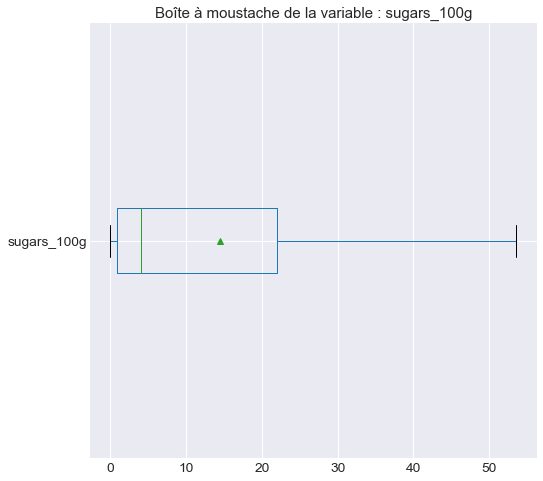

sugars_100g skewness : 1.7002453156446913 

La distribution est étalée à droite 



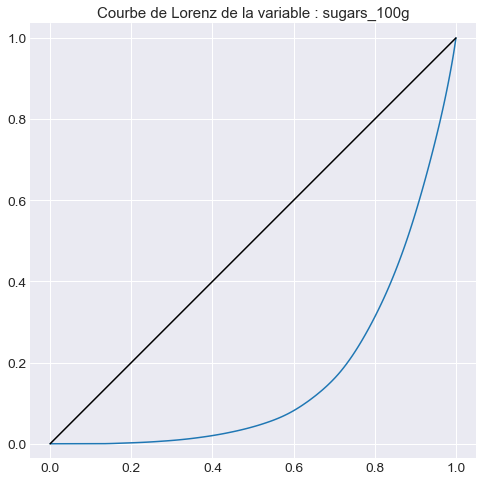

Indice de Gini de sugars_100g : 0.6712755945802416


In [8]:
univariee('sugars_100g')

75% des produits ont entre 0 et 20g de sucre pour 100g de produits. Plusieurs milliers de produits ont tout de même entre 20 et 60g de sucre pour 100g de produits, très peu ont plus de 60g de teneur en sucre.

La distribution est très inégalitaire (indice de Gini de 0.67), on retrouve la même forme que notre courbe de Lorenz. Ici aussi, 60% des produits représentent 10% des valeurs de la distribution.

proteins_100g
moyenne : 8.38
médiane : 6.0
mode : 0    0.0
dtype: float64
variance : 93.98
écart-type : 9.69


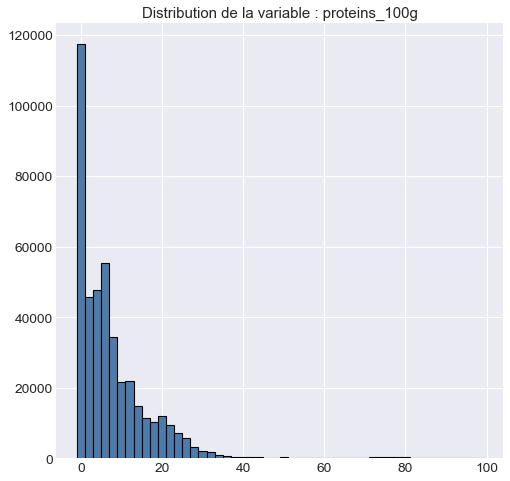

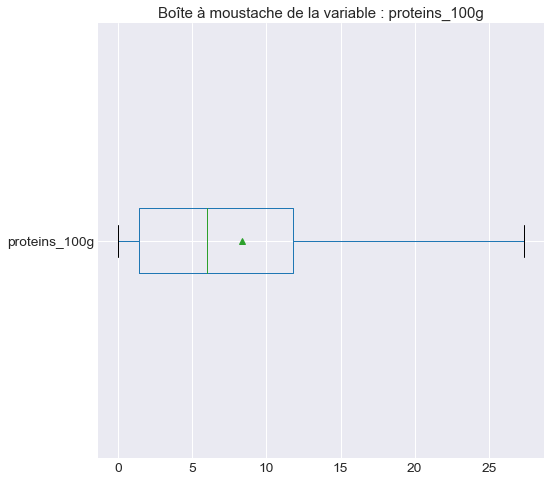

proteins_100g skewness : 3.024802988383435 

La distribution est étalée à droite 



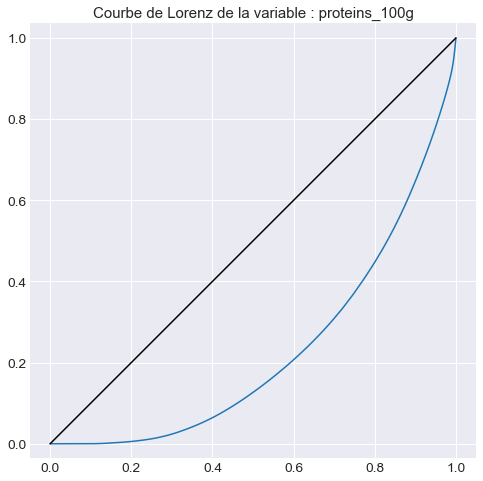

Indice de Gini de proteins_100g : 0.5444536687576407


In [9]:
univariee('proteins_100g')

75% des produits ont entre 0 et 12g de protéines pour 100g de produits. Quasiment plus aucun produit n'a plus de 30g de protéines pour 100g de produits.

La distribution est inégalitaire (indice de Gini de 0.54) : 60% de mes produits représentent environ 20% des valeurs de la distribution.

sodium_100g
moyenne : 0.34
médiane : 0.22
mode : 0    0.0
dtype: float64
variance : 0.18
écart-type : 0.42


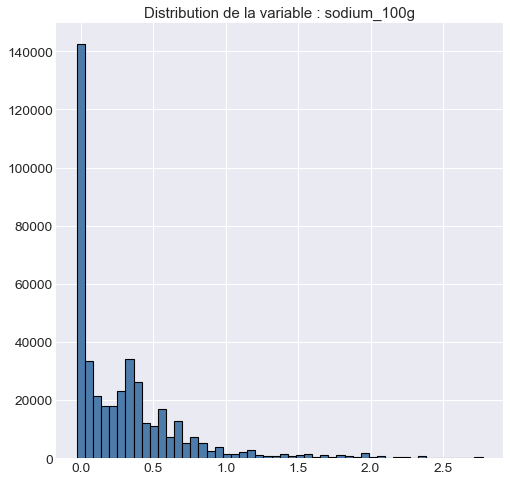

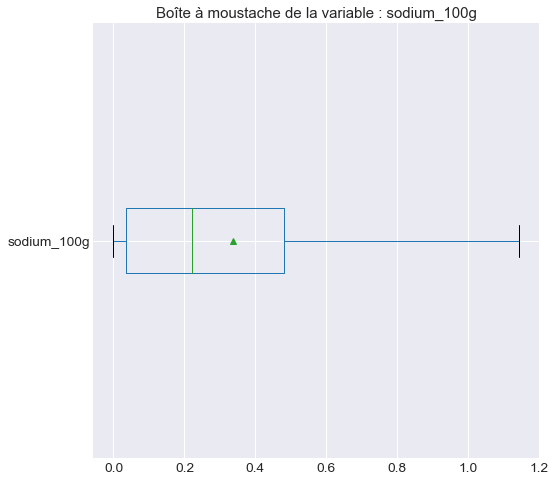

sodium_100g skewness : 2.2722226449242657 

La distribution est étalée à droite 



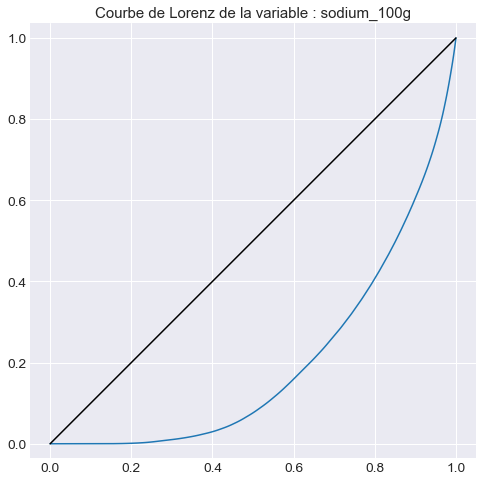

Indice de Gini de sodium_100g : 0.6008587918050049


In [10]:
univariee('sodium_100g')

75% des produits ont entre 0 et 0.5g de sodium pour 100g de produits, très peu de produit n'a plus de 1g de sodium pour 100g.

La distribution est très inégalitaire (indice de Gini de 0.60) : 80% des produits représentent 40% des valeurs de la distribution.

nutriscore_score
moyenne : 9.5
médiane : 9.75
mode : 0    0.0
dtype: float64
variance : 75.1
écart-type : 8.67


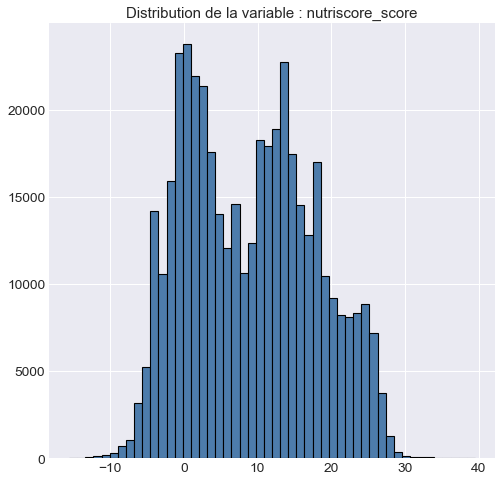

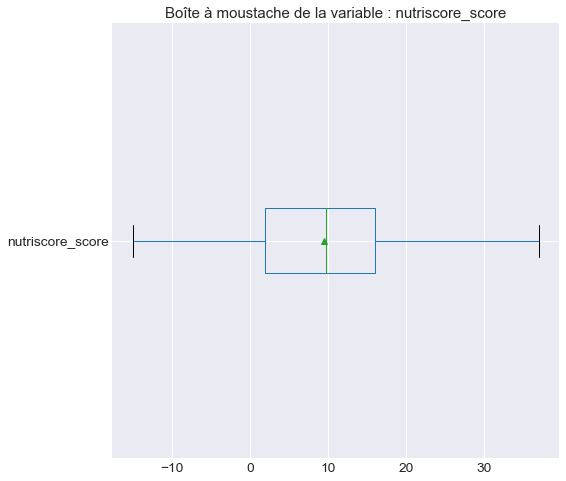

nutriscore_score skewness : 0.19912068188066653 

La distribution est étalée à droite 



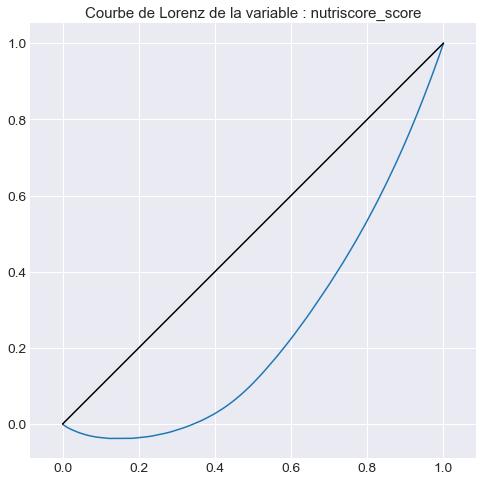

Indice de Gini de nutriscore_score : 0.523425222678442


In [11]:
univariee('nutriscore_score')

Environ 75% des produits ont un score entre 0 et 14. Très peu de produits ont un score inférieur à -10 ou supérieur à 30 (donc très peu de produits très bon et très peu de produits très mauvais).

La distribution est inégalitaire (indice de Gini de 0.51) : 60% de mes produits représentent 25% des valeurs de la distribution.

nutriscore_grade_distrib
moyenne : 3.27
médiane : 3.0
mode : 0    4
dtype: int64
variance : 1.67
écart-type : 1.29


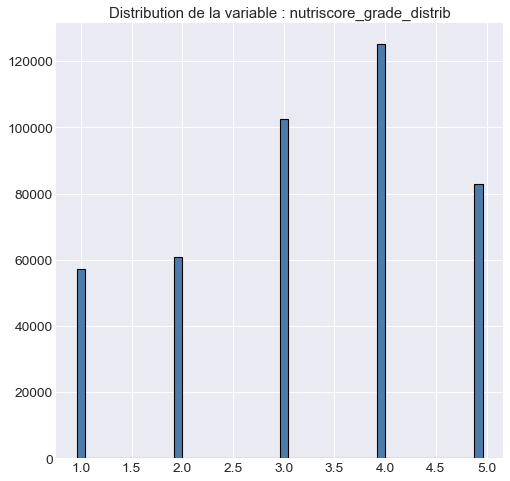

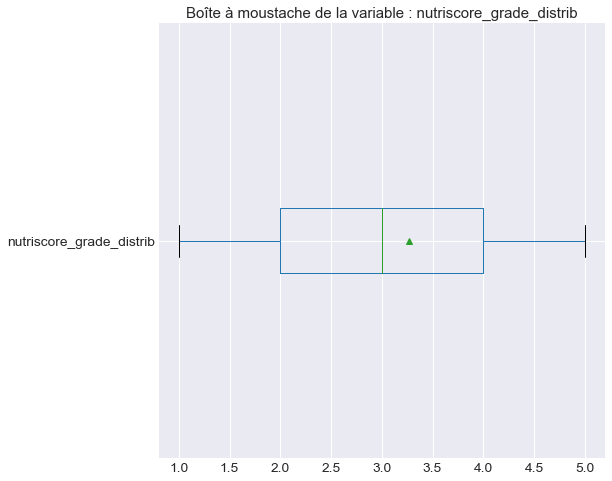

nutriscore_grade_distrib skewness : -0.3430707027087406 

La distribution est étalée à gauche 



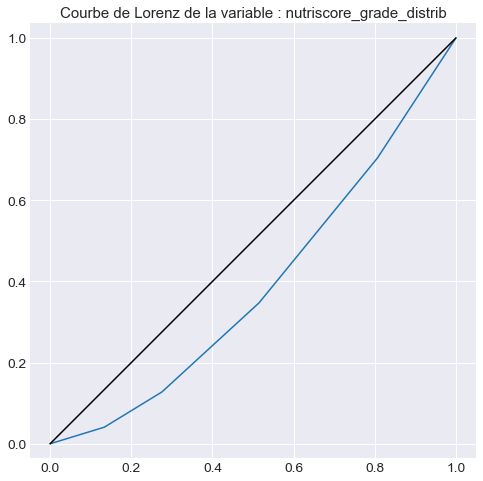

Indice de Gini de nutriscore_grade_distrib : 0.2205700254034353


In [12]:
univariee('nutriscore_grade_distrib')

La majorité des nutriscores vont avoir des notes moyennes / mauvaises avec beaucoup de "c", "d" et "e". Mais, on peut noter que plusieurs dizaines de milliers de produits ont des bons socres ("a" et "b"), même si cela reste minoritaire par rapports aux autres notes.

La distribution est légèrement inégalitaire (indice de Gini de 0.20) : 40% de mes produits représentent 25% des valeurs de la distribution.

### Analyses multivariées

De la même manière que nous avons mis en place une fonction pour nos analyses univariées, nous créons une fonction pour nos analyses bivariées.

In [13]:
def bivariee(col1, col2, data = df):
    """
    Prend deux variables d'un dataframe et retourne un nuage de point généré par les deux variables ainsi que
    le calcul de leur covariance et coefficient de corrélation (si les deux variables sont quantitatives).
    Si une variable est qualitative et une est quantitative, un test ANOVA est réalisé. Si les deux variables
    sont qualitatives, un test de Khi 2 est réalisé.

            Parameters:
                col1 : première colonne de DataFrame que l'on veut comparer
                col2 : deuxième colonne de DataFrame que l'on veut comparer
                data : dataframe à utiliser
    """
    
    #On prend les couleurs associées généralement aux notes du nutriscore
    palette = ['#ff1300', '#ff8a00', '#f8ff00', '#2ee30a', '#157f00']
    
    #Nuage de points entre nos deux variables
    fig = plt.figure(figsize = (10, 10))
    sns.scatterplot(x = col1, y = col2, hue = 'nutriscore_grade', palette = palette[::-1],\
                    data = data, alpha = .9)
    plt.legend(title = col1, bbox_to_anchor = (1.30, 1.05))
    plt.show()

    #Si les deux variables sont quantitatives, on calcule la matrice de covariance et la matrice de corrélation
    if (df[col1].dtype == float) | (df[col1].dtype == np.int64):
        if (df[col2].dtype == float) | (df[col2].dtype == np.int64):
            print("La matrice de covariance entre nos variables est :", '\n')
            print(np.cov(df[col1], df[col2]), '\n')
            
            if np.cov(df[col1], df[col2])[0][1] >= 0:
                print("Les variables {} et {} tendent à augmenter ensemble.".format(col1, col2), '\n')
            else:
                print("La variable {} tend à augmenter tandis que {}, et vice-versa.".format(col1, col2), '\n')
            
            corr = df[[col1, col2]].corr()
            print('La matrice de corrélation entre nos variables est :', '\n')
            print(corr, '\n')
            
            if corr.iloc[0, 1] > 0:
                print("Les variables {} et {} sont, a priori, corrélés positivement.".format(col1, col2), '\n')  
            elif corr.iloc[0, 1] < 0:
                print("Les variables {} et {} sont, a priori, anti-corrélés.".format(col1, col2), '\n')
            else:
                print("Les variables {} et {} ne sont, a priori, pas corrélés.".format(col1, col2), '\n')
        
        #Première variable quantitative, deuxième variable qualitative, on effectue un test ANOVA
        else:
            resultat_anova = ols('{} ~ {}'.format(col1, col2),data = df).fit()
            table = sm.stats.anova_lm(resultat_anova)
            pvalue = table['PR(>F)'][0]
            
            if pvalue > 0.05:
                print('pvalue de {} et {} est de'.format(col1, col2), pvalue,\
                      ", il n'y a pas, a priori, de relation entre les variables.", '\n')
            else:
                print('pvalue de {} et {} est de'.format(col1, col2), pvalue,\
                      ", il y a, a priori, une relation entre les variables.", '\n')
    else:
        #Si les deux variables sont qualitatives, on effectue un test de Khi 2
        if df[col2].dtype == object:
            table = pd.crosstab(df[col2],df[col1])
            resultat_khi2 = chi2_contingency(table)
            pvalue = resultat_khi2[1]
            
            if pvalue > 0.05:
                print('pvalue de {} et {} est de'.format(col1, col2), pvalue,\
                      ", il n'y a pas, a priori, de relation entre les variables.", '\n')
            else:
                print('pvalue de {} et {} est de'.format(col1, col2), pvalue,\
                      ", il y a, a priori, une relation entre les variables.", '\n')
                
        else:
            #Première variable qualitative, deuxième variable quantitative, on effectue un test ANOVA
            resultat_anova = ols('{} ~ {}'.format(col2, col1),data = df).fit()
            table = sm.stats.anova_lm(resultat_anova)
            pvalue = table['PR(>F)'][0]
            
            if pvalue > 0.05: 
                print('pvalue de {} et {} est de'.format(col2, col1), pvalue,\
                      ", il n'y a pas, a priori, de relation entre les variables.", '\n')
            else:
                print('pvalue de {} et {} est de'.format(col2, col1), pvalue,\
                      ", il y a, a priori, une relation entre les variables.", '\n')

En ce qui concerne les nuages de points, il convient de rappeler que chaque variable va influer positivement ("proteins_100g") ou négativement ("energy_100g", "saturated_fat_100g", "sodium_100g" et "sugars_100g") sur le calcul de notre score et de notre note, mais au-delà d'un certain seuil, il n'y a plus d'impact. Par exemple, les produits avec 20g de protéines pour 100g de produits n'ont pas plus de points négatifs qu'un produit qui a 12g de protéines. Plus un score est élevé, plus la note sera mauvaise.

De plus, il peut y avoir une juxtaposition de note pour un même score, cela est dû au fait que le système de score dépend du type de produit (eaux, boissons ou aliments solides).

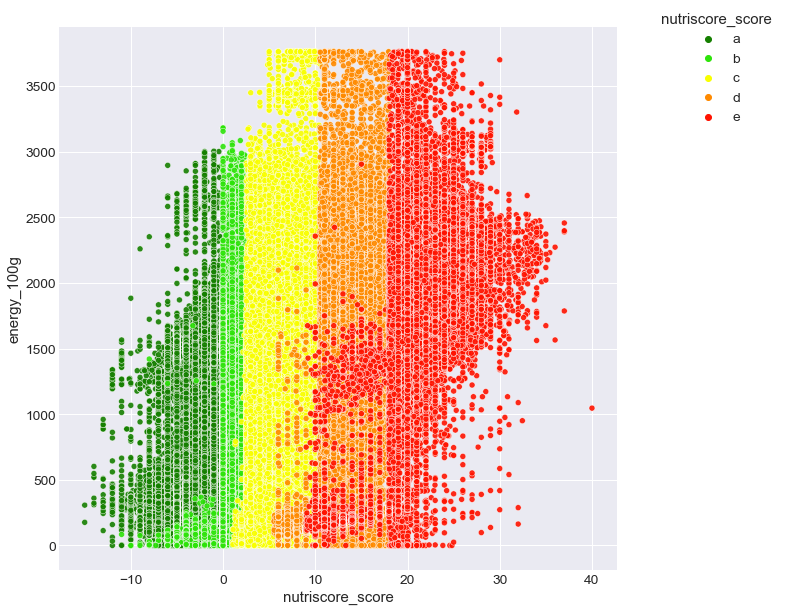

La matrice de covariance entre nos variables est : 

[[7.50991907e+01 4.09284262e+03]
 [4.09284262e+03 5.81156524e+05]] 

Les variables nutriscore_score et energy_100g tendent à augmenter ensemble. 

La matrice de corrélation entre nos variables est : 

                  nutriscore_score  energy_100g
nutriscore_score          1.000000     0.619528
energy_100g               0.619528     1.000000 

Les variables nutriscore_score et energy_100g sont, a priori, corrélés positivement. 



In [14]:
bivariee('nutriscore_score','energy_100g')

On voit une tendance apparaître où plus le produit a une valeur énergétique élevée, plus le score sera important (et donc la note mauvaise). Cela est confirmé par les matrices de covariance et de corrélation.

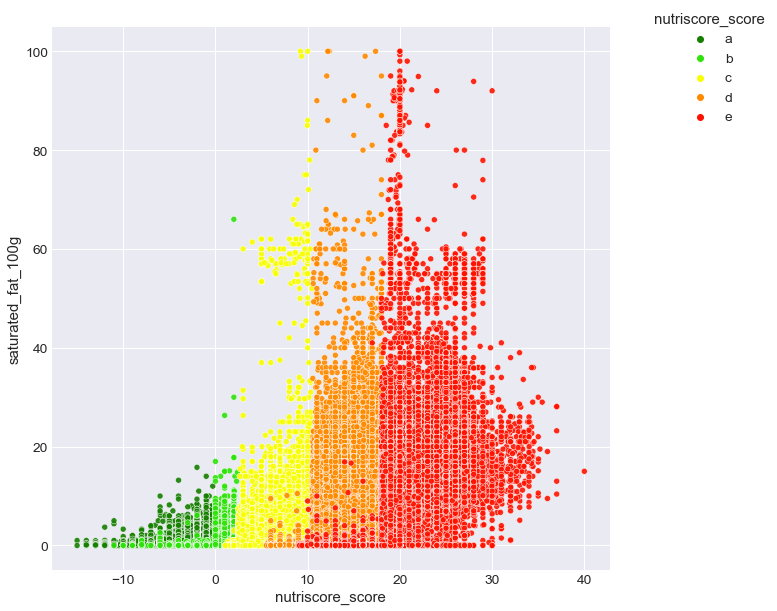

La matrice de covariance entre nos variables est : 

[[75.09919065 41.27044516]
 [41.27044516 56.57990484]] 

Les variables nutriscore_score et saturated_fat_100g tendent à augmenter ensemble. 

La matrice de corrélation entre nos variables est : 

                    nutriscore_score  saturated_fat_100g
nutriscore_score            1.000000            0.633126
saturated_fat_100g          0.633126            1.000000 

Les variables nutriscore_score et saturated_fat_100g sont, a priori, corrélés positivement. 



In [15]:
bivariee('nutriscore_score','saturated_fat_100g')

On trouve ici un nuage de points moins étalé que le précédent et c'est normal : la plupart des produits ont entre 0 et 7.5g de gras saturés pour 100g de produits. Mais encore une fois, on a bien le nutriscore qui augmente (donc la note associée qui se déprécie) lorsque la quantité de gras saturés augmente.

On peut remarquer qu'un certain nombre de produits ont des quantités importantes de gras saturés mais que leur note n'est pas très mauvaise. Cela peut être dû à une erreur humaine ou au fait que les points négatifs dûs au gras saturés sont compensés par un autre élément du produit.

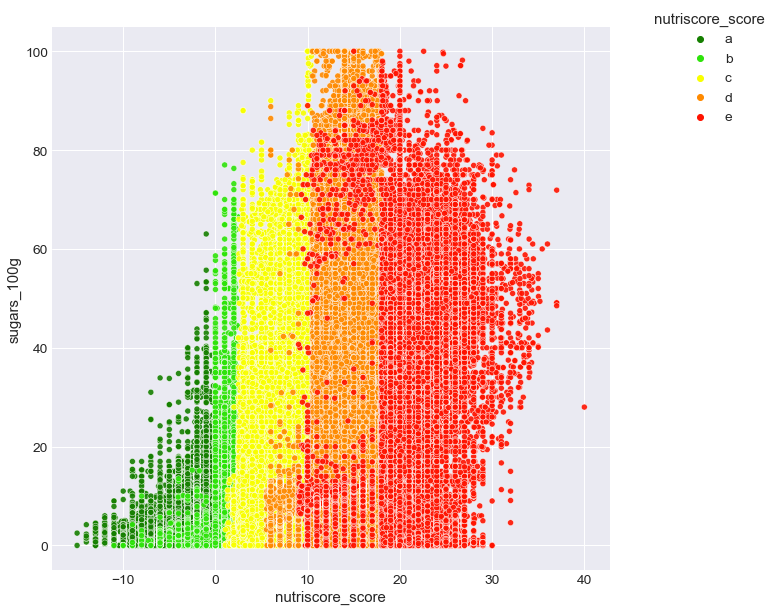

La matrice de covariance entre nos variables est : 

[[ 75.09919065  81.00791205]
 [ 81.00791205 405.47613972]] 

Les variables nutriscore_score et sugars_100g tendent à augmenter ensemble. 

La matrice de corrélation entre nos variables est : 

                  nutriscore_score  sugars_100g
nutriscore_score          1.000000     0.464224
sugars_100g               0.464224     1.000000 

Les variables nutriscore_score et sugars_100g sont, a priori, corrélés positivement. 



In [16]:
bivariee('nutriscore_score','sugars_100g')

Ce nuage de points montre bien les différents paliers lors de l'élaboration du nutriscore : les produits avec plus de 13.5g de sucre ont tous le nombre maximal de points négatifs liés au sucre (10 points). Pourtant, on voit des produits avec 80g de sucre pour 100g de produits qui ont de très bonnes notes.

De plus, grâce à notre analyse univariée, on sait que la majorité de nos produits ont moins de 12.5g de sucre pour 100g, le nuage de points est donc trompeur.

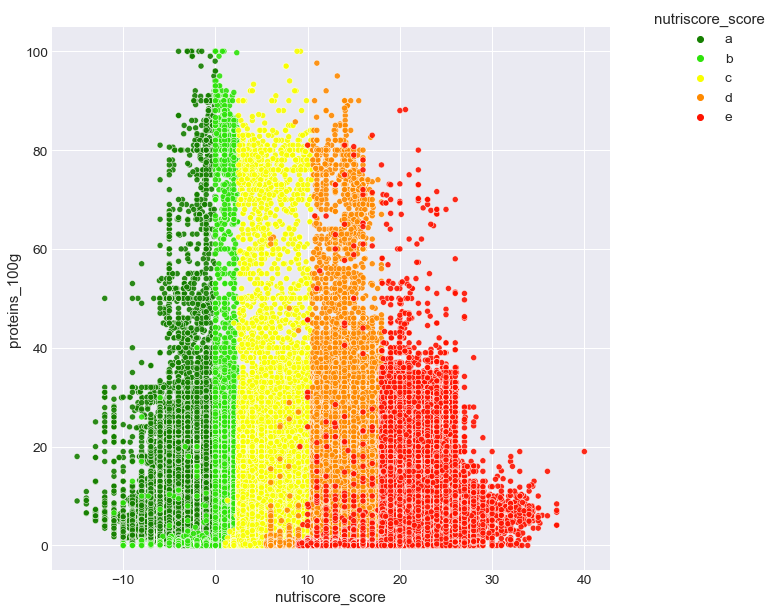

La matrice de covariance entre nos variables est : 

[[75.09919065  4.40207589]
 [ 4.40207589 93.9768278 ]] 

Les variables nutriscore_score et proteins_100g tendent à augmenter ensemble. 

La matrice de corrélation entre nos variables est : 

                  nutriscore_score  proteins_100g
nutriscore_score            1.0000         0.0524
proteins_100g               0.0524         1.0000 

Les variables nutriscore_score et proteins_100g sont, a priori, corrélés positivement. 



In [17]:
bivariee('nutriscore_score','proteins_100g')

La teneur en protéines d'un aliment est un élément positif du nutriscore, c'est-à-dire qu'il le fait diminuer.  En calculant notre matrice de covariance et notre matrice de corrélation, on voit que notre variable "proteins_100g" a tendance à augmenter légèrement avec le nutriscore.  Cela provient probablement du fait qu'un quart de nos produits (d'après notre analyse univariée) à plus de 12g de protéines pour 100g et ont donc atteint le pallier de point de cette variable.

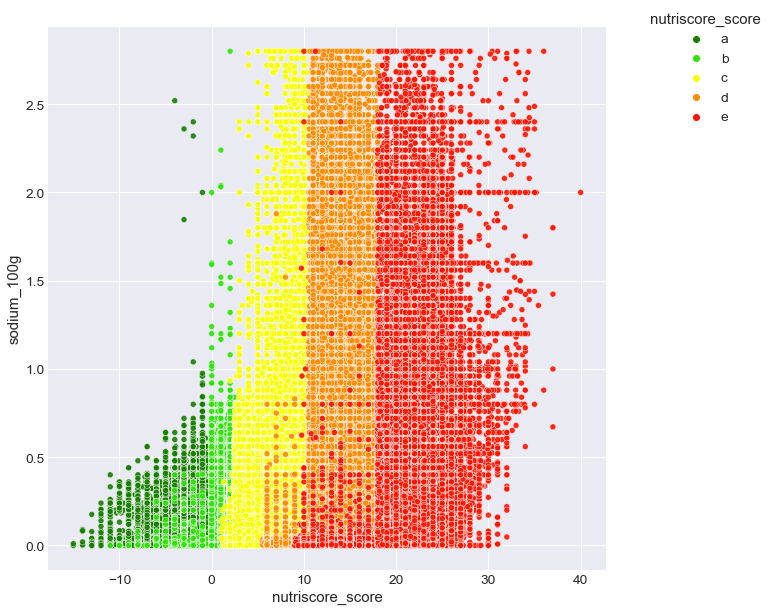

La matrice de covariance entre nos variables est : 

[[75.09919065  1.09403605]
 [ 1.09403605  0.17820575]] 

Les variables nutriscore_score et sodium_100g tendent à augmenter ensemble. 

La matrice de corrélation entre nos variables est : 

                  nutriscore_score  sodium_100g
nutriscore_score          1.000000     0.299056
sodium_100g               0.299056     1.000000 

Les variables nutriscore_score et sodium_100g sont, a priori, corrélés positivement. 



In [18]:
bivariee('nutriscore_score','sodium_100g')

Ici encore, ce nuage de point nous montre l'effet des paliers de point qui est à 0.9g de sodium pour 100g de produit. Encore une fois, les valeurs sont assez tassées, de notre analyse univariée, on sait qu'il y a peu de produit avec plus de 1g de sodium pour 100g. Cependant, on peut remarquer que peu de produits ont plus de 0.9g de sodium pour 100g et ont parallèlement un bon nutriscore.

Calculons maintenant la matrice de corrélation entre toutes nos variables numériques :

In [19]:
df_corr = df.copy()

In [20]:
df_corr.drop(columns = ['code', 'product_name','nutriscore_grade','pnns_groups_2', 'image_url',\
                        'image_small_url', 'additives', 'huile_palme'], inplace = True)

In [21]:
df_corr.corr()

,nutriscore_score,energy_100g,saturated_fat_100g,sugars_100g,proteins_100g,sodium_100g,nutriscore_grade_distrib
nutriscore_score,1.000000,0.619528,0.633126,0.464224,0.052400,0.299056,0.944516
energy_100g,0.619528,1.000000,0.577000,0.344219,0.221863,0.054515,0.530948
saturated_fat_100g,0.633126,0.577000,1.000000,0.088527,0.132423,0.080630,0.552473
sugars_100g,0.464224,0.344219,0.088527,1.000000,-0.253559,-0.284090,0.418055
proteins_100g,0.052400,0.221863,0.132423,-0.253559,1.000000,0.330903,0.025425
sodium_100g,0.299056,0.054515,0.080630,-0.284090,0.330903,1.000000,0.288864
nutriscore_grade_distrib,0.944516,0.530948,0.552473,0.418055,0.025425,0.288864,1.000000


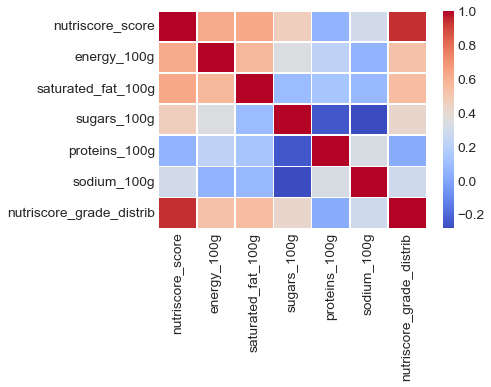

In [22]:
#Graphiquement avec une heatmap :
h = sns.heatmap(df_corr.corr(), linewidth = 0.5, cmap = "coolwarm")

### Visuel de notre application

In [23]:
#On prend aléatoirement 20 produits de notre jeu de données
sample = df.sample(n = 20)

#On remplace nos notes par des majuscules
sample['nutriscore_grade'] = sample['nutriscore_grade'].str.upper()

#On compte chacune de nos différentes notes afin de pouvoir faire un pie-chart par la suite
grade = sample['nutriscore_grade'].value_counts()
grade = grade.sort_index(ascending = False)

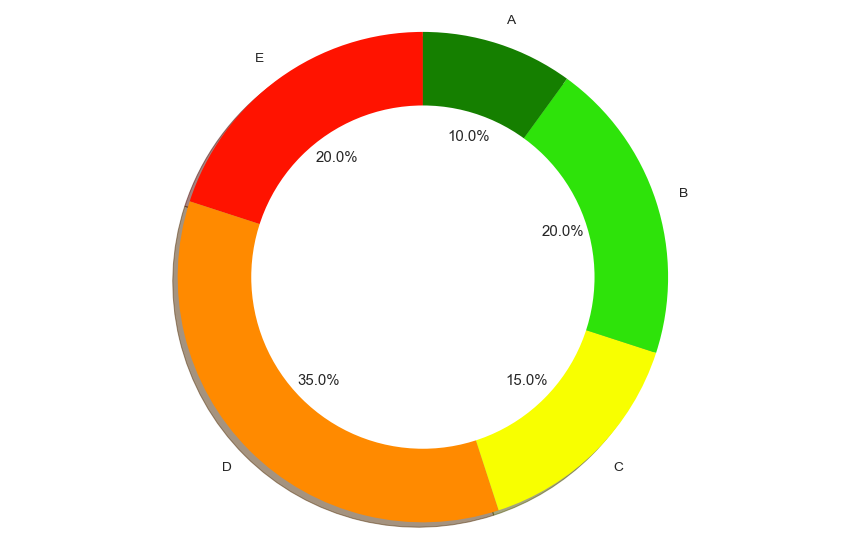

In [24]:
#On veut la répartition de nos produits selon leur nutriscore
labels = grade.index
sizes = grade.values
palette = ['#ff1300', '#ff8a00', '#f8ff00', '#2ee30a', '#157f00']

fig = plt.figure(figsize = (12, 8))

plt.pie(sizes, labels = labels, colors = palette, autopct = '%1.1f%%', shadow = True, startangle = 90)

centre_circle = plt.Circle((0,0),0.70,fc = 'white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.tight_layout()

plt.axis('equal')

plt.show()

In [25]:
#On ne garde que les colonnes nécessaires à l'application
sample = sample[['code', 'product_name', 'nutriscore_grade', 'additives',\
                         'huile_palme', 'image_small_url']]

#On renomme nos colonnes pour plus de lisibilité
sample.rename(columns = {'code': 'Code Barre', 'product_name': 'Produit',\
                                 'nutriscore_grade': 'Note', 'additives': 'Additif ?',\
                                 'huile_palme': 'Huile de palme ?', 'image_small_url': 'Image'}, inplace = True)

sample.set_index('Code Barre', inplace = True)

On crée une fonction afin de pouvoir faire apparaître les photos des produits directement dans notre jeu de données.  Le principe serait le même dans l'application : les informations sur le produit ainsi que la photo afin que le consommateur puisse vérifier qu'il s'agisse du bon produit.

In [26]:
def path_to_image_html(path):
    '''
    Prend le lien url d'une image afin de pouvoir l'afficher dans un DataFrame. Possibilité d'ajuster
    la taille dans le DataFrame.
    '''

    return '<img src="'+ path + '" style=max-height:124px;"/>'

HTML(sample.to_html(escape = False, formatters = dict(Image = path_to_image_html)))

,Produit,Note,Additif ?,Huile de palme ?,Image
Code Barre,,,,,
0208067025589,CROQUE SAUMON E.LECLERC 35760,E,Pas d'additif a priori !,Pas d'huile de palme a priori !,
3340790000215,Sauce Antillaise Dame Besson,C,Attention traces possible d'additifs !,Pas d'huile de palme a priori !,
3321950027341,Délice de foie de porc,E,Pas d'additif a priori !,Pas d'huile de palme a priori !,
8423903005446,Bio Int Flocons D'avoine,A,Pas d'additif a priori !,Pas d'huile de palme a priori !,
3029330068945,Mini toast briochés 255g,B,Attention traces possible d'additifs !,Pas d'huile de palme a priori !,
20692414,Proviact Fraise,B,Pas d'additif a priori !,Pas d'huile de palme a priori !,
3760267541421,Creme glacee amande,C,Pas d'additif a priori !,Pas d'huile de palme a priori !,
3177180000452,boeuf charolais seche,D,Pas d'additif a priori !,Pas d'huile de palme a priori !,
5051882270468,Lentilles rouges aux champignons façons risoto,D,Pas d'additif a priori !,Pas d'huile de palme a priori !,


In [27]:
#On donne la possibilité à l'utilisateur de rajouter le produit s'il n'existe pas dans la base de donnée
print("Un produit n'est pas présent ? Ajoutez le !")

Un produit n'est pas présent ? Ajoutez le !


### Pertinence et faisabilité de notre application :

#### 1) Trop de "unknown" dans nos catégories

In [28]:
pie = df['pnns_groups_2'].value_counts()
print('Il y a',pie.sum(),'produits dans notre jeu de données.', '\n')
print('Il y a',len(pie),'catégories de produit.', '\n')
print('Les 29 catégories comportant le moins de produits représentent', pie.tail(29).sum(), 'produits.')

Il y a 428880 produits dans notre jeu de données. 

Il y a 38 catégories de produit. 

Les 29 catégories comportant le moins de produits représentent 82590 produits.


Beaucoup de catégories représentent peu de produits, nous allons garder les 9 premières et regrouper toutes les autres sous le nom "Others".

In [29]:
pie_bis = pd.Series(pie.tail(29).sum())
pie = pie.head(9)
pie = pie.append(pie_bis)
pie.index = ['unknown', 'Biscuits and cakes', 'Sweets', 'One-dish meals', 'Processed meat',\
             'Cheese', 'Cereals', 'Dressings and sauces', 'Meat', 'Others']
pie.sort_values(ascending = False, inplace = True)

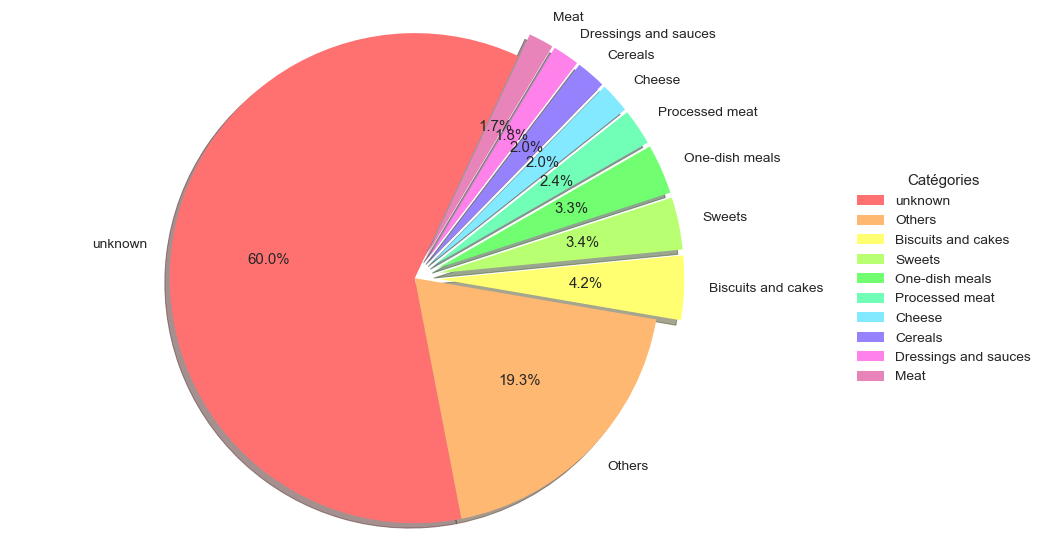

In [30]:
labels = pie.index
sizes = pie.values
explode = (0, 0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)
colors = ['#ff7171', '#ffb871', '#ffff71', '#b8ff71', '#71ff71',\
          '#71ffb8', '#82e9fe', '#9782fe', '#fe82e9', '#e984ba']

fig = plt.figure(figsize = (15, 10))

plt.pie(sizes, labels = labels, explode = explode, colors = colors,  autopct = '%1.1f%%',\
        shadow = True, startangle = 65)

plt.legend(labels, title = "Catégories", loc = "center left", bbox_to_anchor = (1, 0, 0.5, 1))

plt.axis('equal')

plt.show()

#### 2) Des mauvaises habitudes de consommation

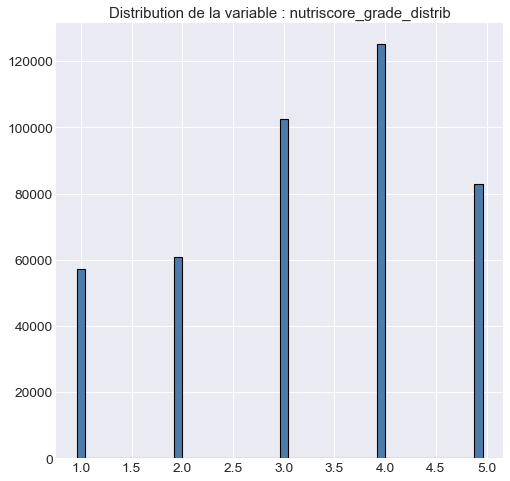

In [31]:
plt.figure(figsize = (8, 8))
plt.hist(x = df['nutriscore_grade_distrib'].values, bins = 50, align = 'left',\
         color = '#4d7cab', edgecolor = 'black', linewidth = 1.1)
plt.title('Distribution de la variable : {}'.format('nutriscore_grade_distrib'))
plt.show()

#### 3) Permet de compenser des manquements au Nutriscore (additifs et huile de palme)

In [32]:
df_bis = df.copy()

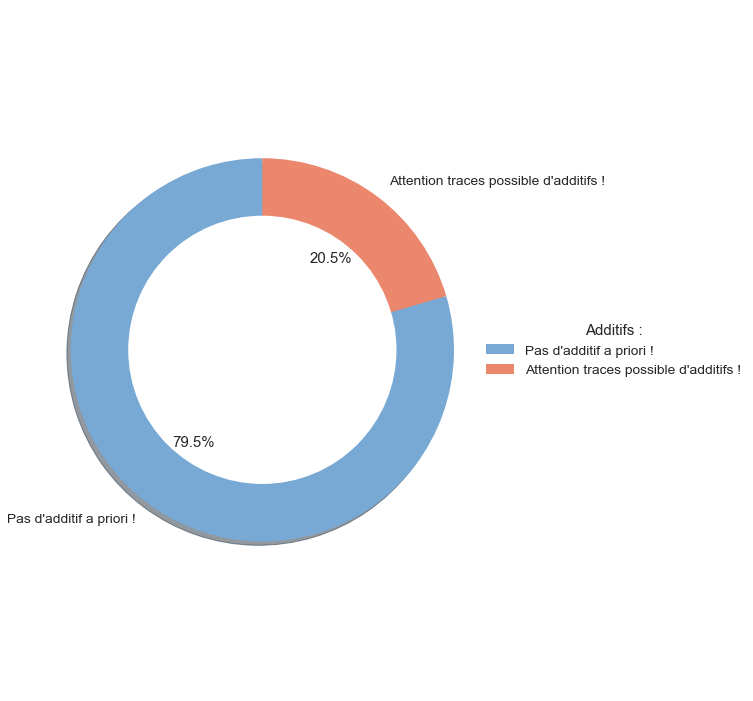

In [33]:
labels_additives = df_bis['additives'].value_counts().index
sizes_additives = df_bis['additives'].value_counts().values
colors = ['#78a8d4', '#ea876d']

fig = plt.figure(figsize = (10, 10))

plt.pie(sizes_additives, labels = labels_additives, colors = colors, \
        autopct = '%1.1f%%', shadow = True, startangle = 90)

plt.legend(labels_additives, title = "Additifs :", loc = "center left", bbox_to_anchor = (1, 0, 0.5, 1))

centre_circle = plt.Circle((0,0),0.70,fc = 'white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.tight_layout()

plt.axis('equal')

plt.show()

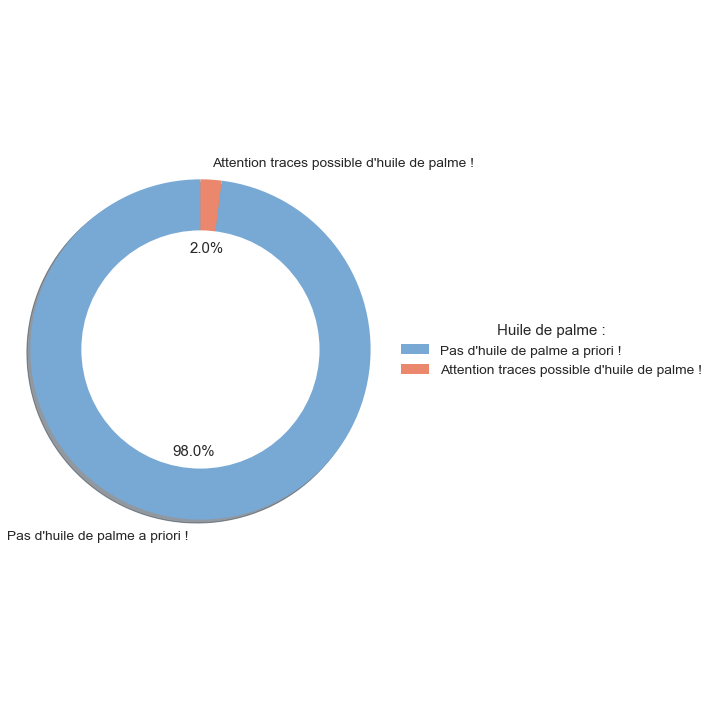

In [34]:
labels_additives = df_bis['huile_palme'].value_counts().index
sizes_additives = df_bis['huile_palme'].value_counts().values

fig = plt.figure(figsize = (10, 10))

plt.pie(sizes_additives, labels = labels_additives, colors = colors,\
        autopct = '%1.1f%%', shadow = True, startangle = 90)

plt.legend(labels_additives, title = "Huile de palme :", loc = "center left", bbox_to_anchor = (1, 0, 0.5, 1))

centre_circle = plt.Circle((0,0),0.70,fc = 'white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.tight_layout()

plt.axis('equal')

plt.show()

### Réduction de dimensionnalité : PCA

In [35]:
df_pca = df[['nutriscore_score', 'energy_100g', 'saturated_fat_100g', 'sugars_100g',\
             'proteins_100g', 'sodium_100g', 'nutriscore_grade_distrib']]

In [36]:
names = df['product_name']

features = df_pca.columns

In [37]:
X = df_pca.values
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [38]:
df_pca.dropna(subset = ['nutriscore_grade_distrib'], inplace = True)

<ipython-input-38-bd8196330b4a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pca.dropna(subset = ['nutriscore_grade_distrib'], inplace = True)


In [39]:
n_comp = 6
pca = decomposition.PCA(n_components = n_comp)
pca.fit(X_scaled)

PCA(n_components=6)

In [40]:
pcs = pca.components_
X_projected = pca.transform(X_scaled)

In [41]:
pcs = pca.components_

In [42]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels = None, label_rotation = 0, lims = None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize = (7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles = 'xy', scale_units = 'xy', scale = 1, color = "grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes = ax, alpha = .1, color = 'black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize = '14', ha = 'center',\
                                 va = 'center', rotation = label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor = 'none', edgecolor = 'b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color = 'grey', ls = '--')
            plt.plot([0, 0], [-1, 1], color = 'grey', ls = '--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels = None, alpha = 1,\
                             illustrative_var = None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2],\
                                alpha = alpha, label = value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize = '14', ha = 'center', va = 'center') 
                
            # détermination des limites du graphique 
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color = 'grey', ls = '--')
            plt.plot([0, 0], [-100, 100], color = 'grey', ls = '--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block = False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(), c = "red", marker = 'o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block = False)

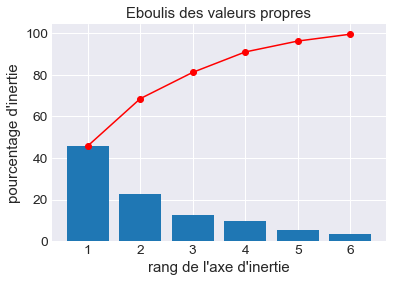

In [43]:
display_scree_plot(pca)

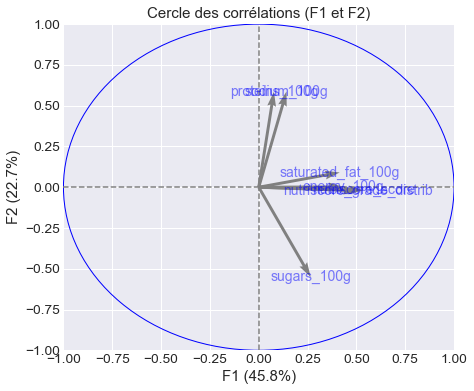

In [44]:
display_circles(pcs, n_comp, pca, [(0, 1)], labels = np.array(features))

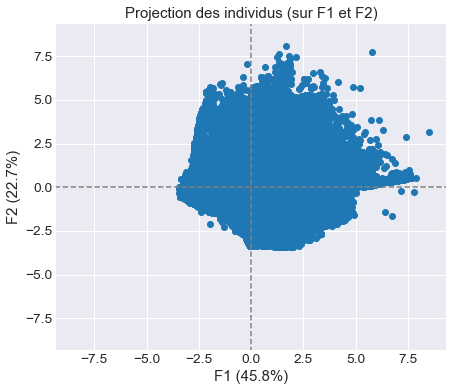

In [45]:
display_factorial_planes(X_projected, n_comp, pca, [(0, 1)])
plt.show()

In [46]:
pd.DataFrame(X_projected, index = df_pca.index, columns = ["F" + str(i+1) for i in range(6)])

,F1,F2,F3,F4,F5,F6
0,-2.428943,-0.454892,0.583073,0.482049,-0.757513,0.122919
1,-1.687347,1.240029,1.712739,-0.967328,-0.435527,0.166290
2,-1.818557,0.135495,1.360072,-1.054485,0.089541,0.535532
3,-2.219364,0.115776,0.133426,0.293913,-0.574384,0.466463
4,-1.497748,1.474193,2.359199,-1.241806,0.225870,0.337530
...,...,...,...,...,...,...
428875,2.231410,-0.621641,-0.022922,0.106703,0.309213,-0.395686
428876,3.616352,-0.507492,1.620412,1.508908,0.324746,0.456745
428877,3.700108,-1.288224,0.710684,0.160078,0.321077,0.592127
428878,2.947983,-1.729730,0.220379,-0.276344,0.466948,0.239521


In [47]:
f1 = pca.components_[0]
f2 = pca.components_[1]
print(f1, '\n')
print(f2)

[0.53494002 0.433545   0.41450056 0.26571294 0.07784002 0.14225723
 0.50711698] 

[-0.01909282  0.00211271  0.0905273  -0.55085628  0.58556393  0.58706198
 -0.02159371]
